# Find the fingerprints of ENSO and the IPO in observed gridded datasets

Purpose
-------

    1.    Decompose the temperature time series into Intrinsic Mode Functions (IMFs) using EMD.
            i)  remove monthly climatology
            ii) remove linear trend over timeseries
    2.    Identify and correlate relevant IMFs with known indices for ENSO and IPO.
    3.    Compute slope of relationship between ENSO/IPO and variable of interest to quantify effect of ENSO/IPO


### IMPORTS

In [2]:

import sys
import os
import glob

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import cmocean.cm as cmo
from cmocean.tools import lighten
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# oceanographic
import gsw as gsw

# statistics
import scipy as sci
from scipy.signal import hilbert
from PyEMD import EMD

# regridding package
import xesmf as xe

# Copernicus marine toolbox
#import copernicusmarine
#from pprint import pprint
#copernicusmarine.login()

# print versions of packages
print("python version =",sys.version[:5])
print("numpy version =", np.__version__)
print("pandas version =", pd.__version__)
print("scipy version =", sci.__version__)
print("xarray version =", xr.__version__)
print("xesmf version =", xe.__version__)
print("cartopy version =", sys.modules[ccrs.__package__].__version__)
print("matplotlib version =", sys.modules[plt.__package__].__version__)
print("cmocean version =", sys.modules[cmo.__package__].__version__)


wrkdir="/g/data/es60/pjb581/SPC"
os.chdir(wrkdir)
os.getcwd()


python version = 3.10.
numpy version = 2.1.3
pandas version = 2.2.3
scipy version = 1.15.1
xarray version = 2024.11.0
xesmf version = 0.8.8
cartopy version = 0.24.0
matplotlib version = 3.10.0
cmocean version = v3.0.3


'/g/data/es60/pjb581/SPC'

## Load the IMFs of the observations

In [3]:
%%time

os.chdir(wrkdir + "/data/")
imfs_sst_ds = xr.open_dataset("imfs_sst.nc")
imfs_mld_ds = xr.open_dataset("imfs_mld.nc")
imfs_oxy200m_ds = xr.open_dataset("imfs_oxy200m.nc")
imfs_oxycline_ds = xr.open_dataset("imfs_oxycline.nc")
imfs_p50_critz_ds = xr.open_dataset("imfs_p50_critz.nc")
imfs_pO2_m_p50_z50_ds = xr.open_dataset("imfs_pO2_m_p50_z50.nc")
imfs_pO2_m_p50_z100_ds = xr.open_dataset("imfs_pO2_m_p50_z100.nc")
imfs_pO2_m_p50_z150_ds = xr.open_dataset("imfs_pO2_m_p50_z150.nc")
imfs_pO2_m_p50_z200_ds = xr.open_dataset("imfs_pO2_m_p50_z200.nc")
imfs_pO2_m_p50_z250_ds = xr.open_dataset("imfs_pO2_m_p50_z250.nc")
imfs_pO2_m_p50_z300_ds = xr.open_dataset("imfs_pO2_m_p50_z300.nc")
imfs_chl_ds = xr.open_dataset("imfs_chl.nc")

sst_trend = imfs_sst_ds['sst_trend']
mld_trend = imfs_mld_ds['mld_trend']
oxy200m_trend = imfs_oxy200m_ds['oxy200m_trend']
oxycline_trend = imfs_oxycline_ds['oxycline_trend']
p50_critz_trend = imfs_p50_critz_ds['p50_critz_trend']
chl_trend = imfs_chl_ds['chl_trend']

sst_imfs = imfs_sst_ds['sst_imfs']
oxy200m_imfs = imfs_oxy200m_ds['oxy200m_imfs']
chl_imfs = imfs_chl_ds['chl_imfs']


CPU times: user 153 ms, sys: 119 ms, total: 271 ms
Wall time: 464 ms


## Load the precooked correlations and effects of ENSO and IPO

In [4]:
os.chdir(wrkdir + "/data")

enso_sst_ccoef = xr.open_dataset("sst_corr_ENSO_IPO.nc")["sst_corr_enso"]
ipo_sst_ccoef = xr.open_dataset("sst_corr_ENSO_IPO.nc")["sst_corr_ipo"]
enso_sst_effect = xr.open_dataset("sst_effect_ENSO_IPO.nc")["sst_effect_enso"]
ipo_sst_effect = xr.open_dataset("sst_effect_ENSO_IPO.nc")["sst_effect_ipo"]

enso_mld_ccoef = xr.open_dataset("mld_corr_ENSO_IPO.nc")["mld_corr_enso"]
ipo_mld_ccoef = xr.open_dataset("mld_corr_ENSO_IPO.nc")["mld_corr_ipo"]
enso_mld_effect = xr.open_dataset("mld_effect_ENSO_IPO.nc")["mld_effect_enso"]
ipo_mld_effect = xr.open_dataset("mld_effect_ENSO_IPO.nc")["mld_effect_ipo"]

enso_oxy200m_ccoef = xr.open_dataset("oxy200m_corr_ENSO_IPO.nc")["oxy200m_corr_enso"]
ipo_oxy200m_ccoef = xr.open_dataset("oxy200m_corr_ENSO_IPO.nc")["oxy200m_corr_ipo"]
enso_oxy200m_effect = xr.open_dataset("oxy200m_effect_ENSO_IPO.nc")["oxy200m_effect_enso"]
ipo_oxy200m_effect = xr.open_dataset("oxy200m_effect_ENSO_IPO.nc")["oxy200m_effect_ipo"]

enso_oxycline_ccoef = xr.open_dataset("oxycline_corr_ENSO_IPO.nc")["oxycline_corr_enso"]
ipo_oxycline_ccoef = xr.open_dataset("oxycline_corr_ENSO_IPO.nc")["oxycline_corr_ipo"]
enso_oxycline_effect = xr.open_dataset("oxycline_effect_ENSO_IPO.nc")["oxycline_effect_enso"]
ipo_oxycline_effect = xr.open_dataset("oxycline_effect_ENSO_IPO.nc")["oxycline_effect_ipo"]

enso_p50_critz_ccoef = xr.open_dataset("p50_critz_corr_ENSO_IPO.nc")["p50_critz_corr_enso"]
ipo_p50_critz_ccoef = xr.open_dataset("p50_critz_corr_ENSO_IPO.nc")["p50_critz_corr_ipo"]
enso_p50_critz_effect = xr.open_dataset("p50_critz_effect_ENSO_IPO.nc")["p50_critz_effect_enso"]
ipo_p50_critz_effect = xr.open_dataset("p50_critz_effect_ENSO_IPO.nc")["p50_critz_effect_ipo"]

enso_chl_ccoef = xr.open_dataset("chl_corr_ENSO_IPO.nc")["chl_corr_enso"]
ipo_chl_ccoef = xr.open_dataset("chl_corr_ENSO_IPO.nc")["chl_corr_ipo"]
enso_chl_effect = xr.open_dataset("chl_effect_ENSO_IPO.nc")["chl_effect_enso"]
ipo_chl_effect = xr.open_dataset("chl_effect_ENSO_IPO.nc")["chl_effect_ipo"]

enso_p50_critz_ccoef

<xarray.DataArray 'p50_critz_corr_enso' (coef_pval: 2, lat: 145, lon: 360)> Size: 835kB
[104400 values with dtype=float64]
Coordinates:
  * coef_pval  (coef_pval) int64 16B 0 1
  * lat        (lat) float32 580B -64.5 -63.5 -62.5 -61.5 ... 77.5 78.5 79.5
  * lon        (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5

## effects

CPU times: user 5min 43s, sys: 434 ms, total: 5min 44s
Wall time: 5min 54s


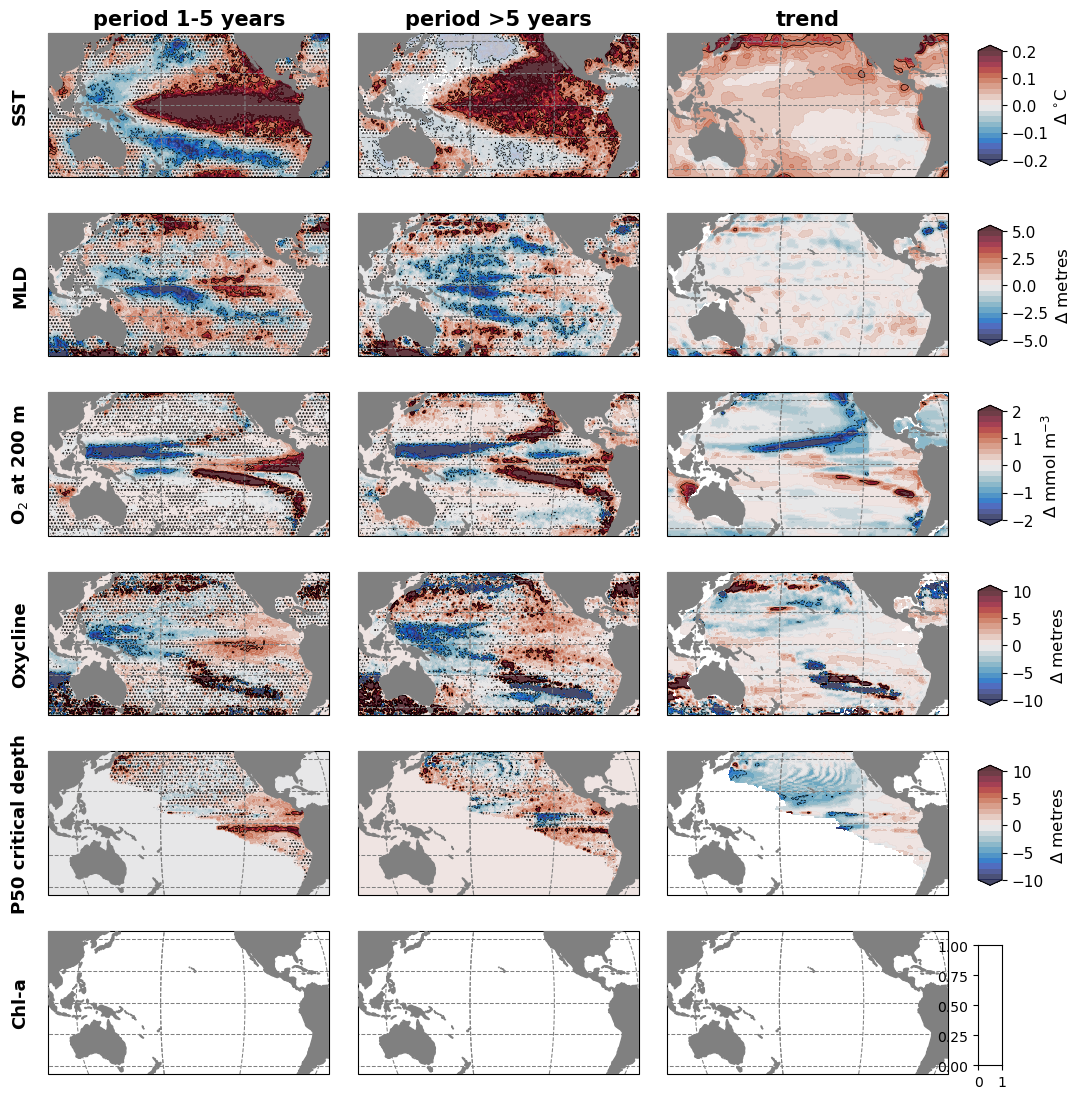

In [6]:
%%time

lon_sst = sst_imfs.coords['lon'].values
lat_sst = sst_imfs.coords['lat'].values
lon_oxy = oxy200m_imfs.coords['lon'].values
lat_oxy = oxy200m_imfs.coords['lat'].values
lon_chl = chl_imfs.coords['lon'].values
lat_chl = chl_imfs.coords['lat'].values

fslab = 15
fstic = 13

proj = ccrs.Robinson(central_longitude=205)

colmap = lighten(cmo.balance, 0.8)

### SST change per unit mode
levs1 = np.arange(-10,11,1)*0.02
contlevs1 = [-0.1, 0.1]

### MLD change per unit mode
levs2 = np.arange(-10,11,1)*0.5
contlevs2 = [-2.5, 2.5]

### O2 change per unit mode
levs3 = np.arange(-1,1.1,0.1)*2
contlevs3 = [-1, 1]

### Oxycline change per unit mode
levs4 = np.arange(-10,11,1)
contlevs4 = [-5, 5]

### P50crit change per unit mode
levs5 = np.arange(-10,11,1)
contlevs5 = [-5, 5]

### Chl change per unit mode
levs6 = np.arange(-10,11,1)*0.01
contlevs6 = [-0.05, 0.05]


hatching = [' ', '.....']
hatchlevs = [0.0, 0.05, 1.0]

fig = plt.figure(figsize=(12,12))
gs = GridSpec(6, 3)

ax1 = plt.subplot(gs[0,0], projection=proj)
ax2 = plt.subplot(gs[0,1], projection=proj)
ax3 = plt.subplot(gs[0,2], projection=proj)
ax4 = plt.subplot(gs[1,0], projection=proj)
ax5 = plt.subplot(gs[1,1], projection=proj)
ax6 = plt.subplot(gs[1,2], projection=proj)
ax7 = plt.subplot(gs[2,0], projection=proj)
ax8 = plt.subplot(gs[2,1], projection=proj)
ax9 = plt.subplot(gs[2,2], projection=proj)
ax10 = plt.subplot(gs[3,0], projection=proj)
ax11 = plt.subplot(gs[3,1], projection=proj)
ax12 = plt.subplot(gs[3,2], projection=proj)
ax13 = plt.subplot(gs[4,0], projection=proj)
ax14 = plt.subplot(gs[4,1], projection=proj)
ax15 = plt.subplot(gs[4,2], projection=proj)
ax16 = plt.subplot(gs[5,0], projection=proj)
ax17 = plt.subplot(gs[5,1], projection=proj)
ax18 = plt.subplot(gs[5,2], projection=proj)


p1 = ax1.contourf(lon_sst, lat_sst, enso_sst_effect[0,:,:], cmap=colmap, levels=levs1, extend='both', transform=ccrs.PlateCarree())
ax1.contour(lon_sst, lat_sst, enso_sst_effect[0,:,:], colors='k', linewidths=0.5, levels=contlevs1, transform=ccrs.PlateCarree())
ax1.contourf(lon_sst, lat_sst, enso_sst_effect[3,:,:], colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

p2 = ax2.contourf(lon_sst, lat_sst, ipo_sst_effect[0,:,:], cmap=colmap, levels=levs1, extend='both', transform=ccrs.PlateCarree())
ax2.contour(lon_sst, lat_sst, ipo_sst_effect[0,:,:], colors='k', linewidths=0.5, levels=contlevs1, transform=ccrs.PlateCarree())
ax2.contourf(lon_sst, lat_sst, ipo_sst_effect[3,:,:], colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

p3 = ax3.contourf(lon_sst, lat_sst, sst_trend*0.1, cmap=colmap, levels=levs1, extend='both', transform=ccrs.PlateCarree())
ax3.contour(lon_sst, lat_sst, sst_trend*0.1, colors='k', linewidths=0.5, levels=contlevs1, transform=ccrs.PlateCarree())

p4 = ax4.contourf(lon_sst, lat_sst, enso_mld_effect[0,:,:]+1e-2, cmap=colmap, levels=levs2, extend='both', transform=ccrs.PlateCarree())
ax4.contour(lon_sst, lat_sst, enso_mld_effect[0,:,:], colors='k', linewidths=0.5, levels=contlevs2, transform=ccrs.PlateCarree())
ax4.contourf(lon_sst, lat_sst, enso_mld_effect[3,:,:], colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

p5 = ax5.contourf(lon_sst, lat_sst, ipo_mld_effect[0,:,:], cmap=colmap, levels=levs2, extend='both', transform=ccrs.PlateCarree())
ax5.contour(lon_sst, lat_sst, ipo_mld_effect[0,:,:], colors='k', linewidths=0.5, levels=contlevs2, transform=ccrs.PlateCarree())
ax5.contourf(lon_sst, lat_sst, ipo_mld_effect[3,:,:], colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

p6 = ax6.contourf(lon_sst, lat_sst, mld_trend*0.1, cmap=colmap, levels=levs2, extend='both', transform=ccrs.PlateCarree())
ax6.contour(lon_sst, lat_sst, mld_trend*0.1, colors='k', linewidths=0.5, levels=contlevs2, transform=ccrs.PlateCarree())

p7 = ax7.contourf(lon_oxy, lat_oxy, enso_oxy200m_effect[0,:,:]+1e-2, cmap=colmap, levels=levs3, extend='both', transform=ccrs.PlateCarree())
ax7.contour(lon_oxy, lat_oxy, enso_oxy200m_effect[0,:,:], colors='k', linewidths=0.5, levels=contlevs3, transform=ccrs.PlateCarree())
ax7.contourf(lon_oxy, lat_oxy, enso_oxy200m_effect[3,:,:], colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

p8 = ax8.contourf(lon_oxy, lat_oxy, ipo_oxy200m_effect[0,:,:], cmap=colmap, levels=levs3, extend='both', transform=ccrs.PlateCarree())
ax8.contour(lon_oxy, lat_oxy, ipo_oxy200m_effect[0,:,:], colors='k', linewidths=0.5, levels=contlevs3, transform=ccrs.PlateCarree())
ax8.contourf(lon_oxy, lat_oxy, ipo_oxy200m_effect[3,:,:], colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

p9 = ax9.contourf(lon_oxy, lat_oxy, oxy200m_trend*0.1, cmap=colmap, levels=levs3, extend='both', transform=ccrs.PlateCarree())
ax9.contour(lon_oxy, lat_oxy, oxy200m_trend*0.1, colors='k', linewidths=0.5, levels=contlevs3, transform=ccrs.PlateCarree())

p10 = ax10.contourf(lon_oxy, lat_oxy, enso_oxycline_effect[0,:,:]+1e-2, cmap=colmap, levels=levs4, extend='both', transform=ccrs.PlateCarree())
ax10.contour(lon_oxy, lat_oxy, enso_oxycline_effect[0,:,:], colors='k', linewidths=0.5, levels=contlevs4, transform=ccrs.PlateCarree())
ax10.contourf(lon_oxy, lat_oxy, enso_oxycline_effect[3,:,:], colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

p11 = ax11.contourf(lon_oxy, lat_oxy, ipo_oxycline_effect[0,:,:]+1e-2, cmap=colmap, levels=levs4, extend='both', transform=ccrs.PlateCarree())
ax11.contour(lon_oxy, lat_oxy, ipo_oxycline_effect[0,:,:], colors='k', linewidths=0.5, levels=contlevs4, transform=ccrs.PlateCarree())
ax11.contourf(lon_oxy, lat_oxy, ipo_oxycline_effect[3,:,:], colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

p12 = ax12.contourf(lon_oxy, lat_oxy, oxycline_trend*0.1, cmap=colmap, levels=levs4, extend='both', transform=ccrs.PlateCarree())
ax12.contour(lon_oxy, lat_oxy, oxycline_trend*0.1, colors='k', linewidths=0.5, levels=contlevs4, transform=ccrs.PlateCarree())

p13 = ax13.contourf(lon_oxy, lat_oxy, enso_p50_critz_effect[0,:,:], cmap=colmap, levels=levs5, extend='both', transform=ccrs.PlateCarree())
ax13.contour(lon_oxy, lat_oxy, enso_p50_critz_effect[0,:,:], colors='k', linewidths=0.5, levels=contlevs5, transform=ccrs.PlateCarree())
ax13.contourf(lon_oxy, lat_oxy, enso_p50_critz_effect[3,:,:], colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

p14 = ax14.contourf(lon_oxy, lat_oxy, ipo_p50_critz_effect[0,:,:]+1e-2, cmap=colmap, levels=levs5, extend='both', transform=ccrs.PlateCarree())
ax14.contour(lon_oxy, lat_oxy, ipo_p50_critz_effect[0,:,:], colors='k', linewidths=0.5, levels=contlevs5, transform=ccrs.PlateCarree())
ax14.contourf(lon_oxy, lat_oxy, ipo_p50_critz_effect[3,:,:], colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

p15 = ax15.contourf(lon_oxy, lat_oxy, p50_critz_trend*0.1, cmap=colmap, levels=levs5, extend='both', transform=ccrs.PlateCarree())
ax15.contour(lon_oxy, lat_oxy, p50_critz_trend*0.1, colors='k', linewidths=0.5, levels=contlevs5, transform=ccrs.PlateCarree())
'''
p16 = ax16.contourf(lon_chl, lat_chl, enso_chl_effect[0,:,:], cmap=colmap, levels=levs6, extend='both', transform=ccrs.PlateCarree())
ax16.contour(lon_chl, lat_chl, enso_chl_effect[0,:,:], colors='k', linewidths=0.5, levels=contlevs6, transform=ccrs.PlateCarree())
ax16.contourf(lon_chl, lat_chl, enso_chl_effect[3,:,:], colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

p17 = ax17.contourf(lon_chl, lat_chl, ipo_chl_effect[0,:,:], cmap=colmap, levels=levs6, extend='both', transform=ccrs.PlateCarree())
ax17.contour(lon_chl, lat_chl, ipo_chl_effect[0,:,:], colors='k', linewidths=0.5, levels=contlevs6, transform=ccrs.PlateCarree())
ax17.contourf(lon_chl, lat_chl, ipo_chl_effect[3,:,:], colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

#p18 = ax18.contourf(lon_chl, lat_chl, chl_trend*0.1, cmap=colmap, levels=levs6, extend='both', transform=ccrs.PlateCarree())
#ax18.contour(lon_chl, lat_chl, chl_trend*0.1, colors='k', linewidths=0.5, levels=contlevs6, transform=ccrs.PlateCarree())
'''

ax1.add_feature(cfeature.LAND, color='grey', zorder=3)
ax2.add_feature(cfeature.LAND, color='grey', zorder=3)
ax3.add_feature(cfeature.LAND, color='grey', zorder=3)
ax4.add_feature(cfeature.LAND, color='grey', zorder=3)
ax5.add_feature(cfeature.LAND, color='grey', zorder=3)
ax6.add_feature(cfeature.LAND, color='grey', zorder=3)
ax7.add_feature(cfeature.LAND, color='grey', zorder=3)
ax8.add_feature(cfeature.LAND, color='grey', zorder=3)
ax9.add_feature(cfeature.LAND, color='grey', zorder=3)
ax10.add_feature(cfeature.LAND, color='grey', zorder=3)
ax11.add_feature(cfeature.LAND, color='grey', zorder=3)
ax12.add_feature(cfeature.LAND, color='grey', zorder=3)
ax13.add_feature(cfeature.LAND, color='grey', zorder=3)
ax14.add_feature(cfeature.LAND, color='grey', zorder=3)
ax15.add_feature(cfeature.LAND, color='grey', zorder=3)
ax16.add_feature(cfeature.LAND, color='grey', zorder=3)
ax17.add_feature(cfeature.LAND, color='grey', zorder=3)
ax18.add_feature(cfeature.LAND, color='grey', zorder=3)


plt.subplots_adjust(top=0.95, right=0.825, left=0.075, wspace=0.1, hspace=0.0, bottom=0.0525)

cbax1 = fig.add_axes([0.85, 0.825, 0.020, 0.1])
cbax2 = fig.add_axes([0.85, 0.675, 0.020, 0.1])
cbax3 = fig.add_axes([0.85, 0.525, 0.020, 0.1])
cbax4 = fig.add_axes([0.85, 0.375, 0.020, 0.1])
cbax5 = fig.add_axes([0.85, 0.225, 0.020, 0.1])
cbax6 = fig.add_axes([0.85, 0.075, 0.020, 0.1])

cbar1 = plt.colorbar(p1, cax=cbax1, orientation='vertical', ticks=levs1[::5])
cbar2 = plt.colorbar(p4, cax=cbax2, orientation='vertical', ticks=levs2[::5])
cbar3 = plt.colorbar(p7, cax=cbax3, orientation='vertical', ticks=levs3[::5])
cbar4 = plt.colorbar(p10, cax=cbax4, orientation='vertical', ticks=levs4[::5])
cbar5 = plt.colorbar(p13, cax=cbax5, orientation='vertical', ticks=levs5[::5])
#cbar6 = plt.colorbar(p16, cax=cbax6, orientation='vertical', ticks=levs6[::5])

cbar1.ax.set_ylabel("$\Delta$ $^{\circ}$C", fontsize=fslab-3)
cbar2.ax.set_ylabel("$\Delta$ metres", fontsize=fslab-3)
cbar3.ax.set_ylabel("$\Delta$ mmol m$^{-3}$", fontsize=fslab-3)
cbar4.ax.set_ylabel("$\Delta$ metres", fontsize=fslab-3)
cbar5.ax.set_ylabel("$\Delta$ metres", fontsize=fslab-3)
#cbar6.ax.set_ylabel("$\Delta$ mg C m$^{-3}$", fontsize=fslab-3)

ax1.text(0.5, 1.1, 'period 1-5 years', fontsize=fslab, fontweight='bold', ha='center', va='center', transform=ax1.transAxes)
ax2.text(0.5, 1.1, 'period >5 years', fontsize=fslab, fontweight='bold', ha='center', va='center', transform=ax2.transAxes)
ax3.text(0.5, 1.1, 'trend', fontsize=fslab, fontweight='bold', ha='center', va='center', transform=ax3.transAxes)

xx = -0.1; yy = 0.5
plt.text(xx, yy, 'SST', ha='center', va='center', fontsize=fstic, fontweight='bold', rotation=90, transform=ax1.transAxes)
plt.text(xx, yy, 'MLD', ha='center', va='center', fontsize=fstic, fontweight='bold', rotation=90, transform=ax4.transAxes)
plt.text(xx, yy, 'O$_2$ at 200 m', ha='center', va='center', fontsize=fstic, fontweight='bold', rotation=90, transform=ax7.transAxes)
plt.text(xx, yy, 'Oxycline', ha='center', va='center', fontsize=fstic, fontweight='bold', rotation=90, transform=ax10.transAxes)
plt.text(xx, yy, 'P50 critical depth', ha='center', va='center', fontsize=fstic, fontweight='bold', rotation=90, transform=ax13.transAxes)
plt.text(xx, yy, 'Chl-a', ha='center', va='center', fontsize=fstic, fontweight='bold', rotation=90, transform=ax16.transAxes)

cbar1.ax.tick_params(labelsize=fstic-2)
cbar2.ax.tick_params(labelsize=fstic-2)
cbar3.ax.tick_params(labelsize=fstic-2)
cbar4.ax.tick_params(labelsize=fstic-2)
cbar5.ax.tick_params(labelsize=fstic-2)
#cbar6.ax.tick_params(labelsize=fstic-2)


lon1 = 100; lon2 = 300
lat1 = -45; lat2 = 45
ax1.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax2.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax3.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax4.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax5.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax6.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax7.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax8.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax9.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax10.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax11.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax12.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax13.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax14.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax15.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax16.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax17.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax18.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())


lcol = 'grey'; lwid = 0.75; lsty = '--'
gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linestyle=lsty, color=lcol, linewidth=lwid)
gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linestyle=lsty, color=lcol, linewidth=lwid)
gl3 = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linestyle=lsty, color=lcol, linewidth=lwid)
gl4 = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linestyle=lsty, color=lcol, linewidth=lwid)
gl5 = ax5.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linestyle=lsty, color=lcol, linewidth=lwid)
gl6 = ax6.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linestyle=lsty, color=lcol, linewidth=lwid)
gl7 = ax7.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linestyle=lsty, color=lcol, linewidth=lwid)
gl8 = ax8.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linestyle=lsty, color=lcol, linewidth=lwid)
gl9 = ax9.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linestyle=lsty, color=lcol, linewidth=lwid)
gl10 = ax10.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linestyle=lsty, color=lcol, linewidth=lwid)
gl11 = ax11.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linestyle=lsty, color=lcol, linewidth=lwid)
gl12 = ax12.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linestyle=lsty, color=lcol, linewidth=lwid)
gl13 = ax13.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linestyle=lsty, color=lcol, linewidth=lwid)
gl14 = ax14.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linestyle=lsty, color=lcol, linewidth=lwid)
gl15 = ax15.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linestyle=lsty, color=lcol, linewidth=lwid)
gl16 = ax16.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linestyle=lsty, color=lcol, linewidth=lwid)
gl17 = ax17.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linestyle=lsty, color=lcol, linewidth=lwid)
gl18 = ax18.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linestyle=lsty, color=lcol, linewidth=lwid)



In [13]:
os.chdir(wrkdir)
fig.savefig("./figures/obs_decomposition_effect.png", dpi=300)
fig.savefig("./figures/obs_decomposition_effect_transparent.png", dpi=300, transparent=True)
